In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Images/2844747252_64567cf14a.jpg  
  inflating: Dataset/Images/2844846111_8c1cbfc75d.jpg  
  inflating: Dataset/Images/2844963839_ff09cdb81f.jpg  
  inflating: Dataset/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Dataset/Images/2845691057_d4ab89d889.jpg  
  inflating: Dataset/Images/2845845721_d0bc113ff7.jpg  
  inflating: Dataset/Images/2846037553_1a1de50709.jpg  
  inflating: Dataset/Images/2846785268_904c5fcf9f.jpg  
  inflating: Dataset/Images/2846843520_b0e6211478.jpg  
  inflating: Dataset/Images/2847514745_9a35493023.jpg  
  inflating: Dataset/Images/2847615962_c330bded6e.jpg  
  inflating: Dataset/Images/2847859796_4d9cb0d31f.jpg  
  inflating: Dataset/Images/2848266893_9693c66275.jpg  
  inflating: Dataset/Images/2848571082_26454cb981.jpg  
  inflating: Dataset/Images/2848895544_6d06210e9d.jpg  
  inflating: Dataset/Images/2848977044_446a31d86e.jpg  
  inflating: Dataset/Images/2849194983_2968c72832.jpg

#Importing Main Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle
import numpy as np
import keras
from tqdm.notebook import tqdm
from keras.applications import Xception
from keras.applications.xception import Xception, preprocess_input
from keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, add
from tensorflow.keras.activations import relu, softmax
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model

#Directory

In [ ]:
photo_dir = r"C:\Users\vivek\OneDrive\Desktop\image_to_text\Dataset"

In [ ]:
directory = r'C:\Users\vivek\OneDrive\Desktop\image_to_text\Dataset\Images'

Dictionary of feature which has image file name with their features

In [ ]:
xcep = Xception(weights='imagenet', include_top=False, pooling='avg')

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
feat = {}

for i in os.listdir(directory):

    img_path = os.path.join(directory, i)
    image = load_img(img_path, target_size=(299, 299))  # Xception requires (299, 299) input shape

    # Converting image pixels into numpy array
    image = img_to_array(image)


    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))


    image = preprocess_input(image)


    feature = xcep.predict(image, verbose=0)


    image_id = i.split('.')[0]

    feat[image_id] = feature


#Reading cations.txt

In [ ]:
with open(os.path.join(photo_dir, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()


#Mapping image ID to a list of its captions

In [ ]:
mapi = {}

for i in captions_doc.split('\n'):
    tokens = i.split(',')

    if len(i) < 2:
        continue

    image_id, j = tokens[0], tokens[1:]

    image_id = image_id.split('.')[0]

    j = " ".join(j)

    if image_id not in mapi:
        mapi[image_id] = []
    mapi[image_id].append(j)

#Cleaning the images

In [ ]:
def clean(mapi):
    for key, captions in mapi.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = re.sub('[^A-Za-z]', '', caption)
            #caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')

            if not caption.startswith('startseq'):
                caption = 'startseq ' + caption
            if not caption.endswith('endseq'):
                caption += ' endseq'

            caption = ' '.join(caption.split())  # Remove extra spaces

            captions[i] = caption

    return mapi

collecting all captions from the mapi dictionary into a single list called all_captions

In [ ]:
all_captions = [i for captions in mapi.values() for i in captions]

#Tokenization

In [ ]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(all_captions)

vocab_size = len(tokenizer.word_index) + 1

max_length = max(len(caption.split()) for caption in all_captions)

image_ids = list(mapi.keys())

In [ ]:
print("vocab_size" , vocab_size)
print("max_length" , max_length)

vocab_size 8494
max_length 37


#Splitting

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(image_ids, test_size=0.10, random_state=42)

#creating batches for effective training

In [ ]:
def data_generator(data_keys, mapi, feat, tokenizer, max_length, vocab_size, batch_size):

    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1

            captions = mapi[key]

            for caption in captions:

                seq = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(feat[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield (X1, X2), y
                X1, X2, y = list(), list(), list()
                n = 0

In [ ]:
max_length = 50
vocab_size = 8497

In [ ]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.2)(inputs1)
fe2 = Dense(1024, activation=relu)(fe1)
fe3 = Dense(512, activation=relu)(fe2)
fe4 = Dense(256, activation=relu)(fe3)
fe5 = Dense(128, activation=relu)(fe4)


inputs2 = Input(shape=(50,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.2)(se1)
se3 = LSTM(128, use_cudnn=False)(se2)

decoder1 = add([fe5, se3])
decoder2 = Dense(128, activation=relu)(decoder1)
outputs = Dense(vocab_size, activation=softmax)(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')


model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 2048)           │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1024)           │      2,098,176 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 512)            │        524,800 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 50, 256)        │      2,175,232 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │        131,328 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 50, 256)        │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 50)             │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 128)            │         32,896 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 128)            │        197,120 │ dropout_1[0][0],       │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_12 (Add)              │ (None, 128)            │              0 │ dense_3[0][0],         │
│                           │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │         16,512 │ add_12[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 8497)           │      1,096,113 │ dense_4[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,272,177 (23.93 MB)

 Trainable params: 6,272,177 (23.93 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print(f"Vocabulary size: {vocab_size}")
print(f"Tokenizer vocab size: {len(tokenizer.word_index) + 1}")

Vocabulary size: 8497
Tokenizer vocab size: 8494


In [ ]:
generator = data_generator(train, mapi, feat, tokenizer, 50, vocab_size, 64)

model.fit(
    generator,
    epochs=10,
    steps_per_epoch=len(train) // 64,
    verbose=1
)

print("Training complete!")


 37/113 ━━━━━━━━━━━━━━━━━━━━ 9:51 8s/step - loss: 7.2703 

# Converting integer token back into its corresponding word

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length ):

    in_text = 'startseq'

    for i in range(50):

        sequence = tokenizer.texts_to_sequences([in_text])[0]

        sequence = pad_sequences([sequence], 50, padding='post')
        yhat = model.predict([image, sequence], verbose=0)

        yhat = np.argmax(yhat)

        word = idx_to_word(yhat, tokenizer)

        if word is None:
            break

        in_text += " " + word

        if word == 'endseq':
            break
    return in_text

In [ ]:
len(test)

810

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

# Generate actual and predicted captions
actual = [[caption.split() for caption in mapi[key]] for key in test]
predicted = [predict_caption(model, feat[key], tokenizer, 50).split() for key in test]

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def display_image(image_path):
    """Display an image given its file path."""
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def print_captions(title, captions):
    """Print a list of captions with a title."""
    print(f'--------------------{title}--------------------')
    for caption in captions:
        print(caption)

def generate_caption(model, image_id, image_directory, mapi, feat, tokenizer, max_length):

    # Get the image path
    img_path = os.path.join(image_directory, "Images", f"{image_id}.jpg")

    # Load actual captions
    actual_captions = mapi.get(image_id, [])
    predicted_caption = predict_caption(model, feat[image_id], tokenizer, max_length)

    # Display actual captions
    print_captions("Actual Captions", actual_captions)

    # Display predicted caption
    print_captions("Predicted Caption", [predicted_caption])

    display_image(img_path)

    return actual_captions, predicted_caption


In [ ]:
max_length

50

--------------------Actual Captions--------------------
A man lays on a bench while his dog sits by him .
A man lays on the bench to which a white dog is also tied .
a man sleeping on a bench outside with a white and black dog sitting next to him .
A shirtless man lies on a park bench with his dog .
man laying on bench holding leash of dog sitting on ground
--------------------Predicted Caption--------------------
startseq black dog in a ball in a ball in a ball in a ball in a ball in a ball in a ball in a ball in a ball in a ball in a ball in a ball in a ball in a ball in a ball in a ball


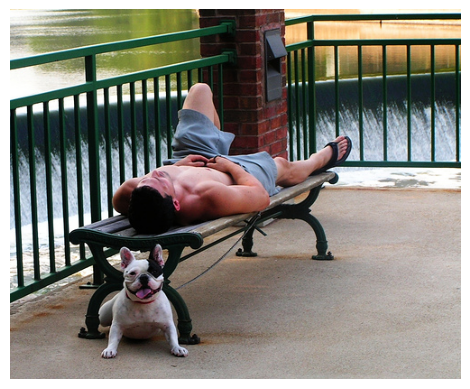

In [ ]:
lst , pred = generate_caption(model, "1003163366_44323f5815", photo_dir, mapi, feat, tokenizer, max_length)

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

for i in captions:
  # Calculate BLEU score
  smooth = SmoothingFunction().method1
  bleu_score = sentence_bleu(i, pred, smoothing_function=smooth)
  print(f"BLEU Score: {bleu_score}")



BLEU Score: 0.001834899046532132
BLEU Score: 0.001834899046532132
BLEU Score: 0.0019489289761442626
BLEU Score: 0.0019131536108597093
BLEU Score: 0.0019489289761442626


#Load the model

In [ ]:
# Save the trained model to a file in the Keras SavedModel format
model.save('my_model.keras')

--------------------Actual Captions--------------------
A man lays on a bench while his dog sits by him .
A man lays on the bench to which a white dog is also tied .
a man sleeping on a bench outside with a white and black dog sitting next to him .
A shirtless man lies on a park bench with his dog .
man laying on bench holding leash of dog sitting on ground
--------------------Predicted Caption--------------------
startseq black dog in a ball in a ball in a ball in a ball in a ball in a ball in a ball in a ball in a ball in a ball in a ball in a ball in a ball in a ball in a ball in a ball


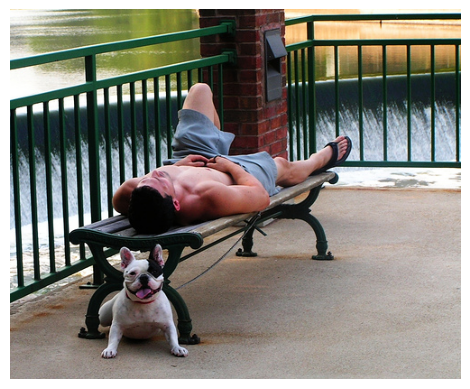

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('my_model.keras')

# Example: Predict captions for a new image
image_features = feat['1003163366_44323f5815']  # Pre-extracted features
sequence = tokenizer.texts_to_sequences(['startseq'])
sequence = pad_sequences(sequence, maxlen=50)

# Generate prediction
yhat = loaded_model.predict([image_features, sequence])
